<a href="https://colab.research.google.com/github/marwanali213/Speech-Recognition-Model-using-Connectionist-Temporal-Classification-CTC-loss-for-seq-to-seq/blob/main/Speech-Recognition-Model-using-Connectionist-Temporal-Classification-CTC-loss-for-seq-to-seq-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

!tar -xf /content/drive/MyDrive/Copy\ of\ LJSpeech-1.1.tar.bz2 -C /content/


In [15]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.6 MB/s eta 0:00:00


## Automatic Speech Recognition using CTC

### The model used in Keras' official code examples for audio data, specifically for automatic speech recognition using CTC.

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [19]:

data_path = '/content/LJSpeech-1.1'
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ030-0240,to that effect immediately after the assassina...
1,LJ024-0004,It is simply this: whenever a judge or justice...
2,LJ019-0220,the uses of Newgate were narrowed almost entir...


In [20]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [21]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_(' ')] (size =31)


In [22]:
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [23]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

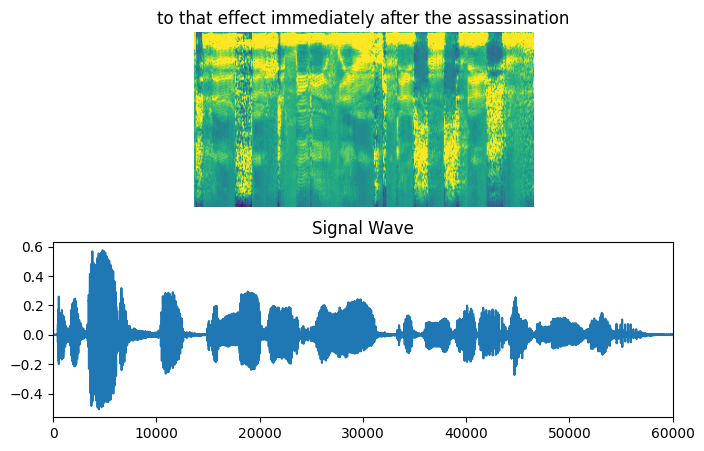

In [24]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()



In [25]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 193)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 193, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 97, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 97, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 97, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 49, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 49, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 49, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1568)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,395,904 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_12 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_13 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_14 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_15 (Dropout)                           │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [27]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [28]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709

In [29]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Now i am trying something to improve loss with a sample (1/4 of the total data) but increasing epochs to 30

Loading complete dataset...
Loading dataset files...


100%|██████████| 13100/13100 [00:00<00:00, 13300.10it/s]


Found 13100 valid audio files
Selected 3275 samples (1/4 of total dataset)
Training samples: 2947
Validation samples: 328
DataGenerator initialized with 2947 samples
First audio path: /content/LJSpeech-1.1/wavs/LJ006-0015.wav
First text: one which required discretion, judgment, and knowledge of law, with sufficient insight and experience to discover defects in prison discipline.
DataGenerator initialized with 328 samples
First audio path: /content/LJSpeech-1.1/wavs/LJ006-0114.wav
First text: They bought their offices from one another, and were thus considered to have a vested interest in them.
Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 11/368 ━━━━━━━━━━━━━━━━━━━━ 1:09 194ms/step - loss: 3218.3508Error processing sample 742: 'float' object has no attribute 'lower'
 93/368 ━━━━━━━━━━━━━━━━━━━━ 1:02 226ms/step - loss: 2516.3325Error processing sample 548: 'float' object has no attribute 'lower'
278/368 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - loss: 2314.3357Error processing sample 444: 'float' object has no attribute 'lower'
320/368 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - loss: 2281.8767Error processing sample 2110: 'float' object has no attribute 'lower'
363/368 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 2249.6074Error processing sample 2334: 'float' object has no attribute 'lower'
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 2246.6704Error processing sample 298: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 2245.9343
Epoch 1: loss improved from inf to 1975.78406, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 108s 274ms/step - loss: 2245.2021 - val_loss: 1455.4752 - learning_rate: 5.0000e-04
Epoch 2/30
112/368 ━━━━━━━━━━━━━━━━━━━━ 59s 231ms/step - loss: 1443.3341Error processing sample 742: 'float' object has no attribute 'lower'
186/368 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - loss: 1420.8579Error processing sample 2334: 'float' object has no attribute 'lower'
202/368 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - loss: 1416.0422Error processing sample 298: 'float' object has no attribute 'lower'
240/368 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - loss: 1405.0884Error processing sample 444: 'float' object has no attribute 'lower'
242/368 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - loss: 1404.5088Error processing sample 548: 'float' object has no attribute 'lower'
332/368 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - loss: 1380.1642Error processing sample 2110: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 1371.2373
Epoch 2: loss improved from 1975.7

368/368 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - loss: 1370.9885 - val_loss: 1013.0934 - learning_rate: 5.0000e-04
Epoch 3/30
 25/368 ━━━━━━━━━━━━━━━━━━━━ 1:08 200ms/step - loss: 1114.3230Error processing sample 298: 'float' object has no attribute 'lower'
156/368 ━━━━━━━━━━━━━━━━━━━━ 47s 223ms/step - loss: 1082.3573Error processing sample 444: 'float' object has no attribute 'lower'
242/368 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - loss: 1068.9283Error processing sample 548: 'float' object has no attribute 'lower'
273/368 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - loss: 1064.1305Error processing sample 2334: 'float' object has no attribute 'lower'
275/368 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - loss: 1063.8130Error processing sample 2110: 'float' object has no attribute 'lower'
297/368 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - loss: 1060.3418Error processing sample 742: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 1049.8549
Epoch 3: loss improved from 1279

368/368 ━━━━━━━━━━━━━━━━━━━━ 142s 255ms/step - loss: 1049.7118 - val_loss: 823.7416 - learning_rate: 5.0000e-04
Epoch 4/30
Error processing sample 2110: 'float' object has no attribute 'lower'
207/368 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - loss: 864.2755Error processing sample 444: 'float' object has no attribute 'lower'
312/368 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - loss: 859.0731Error processing sample 298: 'float' object has no attribute 'lower'
326/368 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - loss: 858.3234Error processing sample 2334: 'float' object has no attribute 'lower'
351/368 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 856.8696Error processing sample 548: 'float' object has no attribute 'lower'
363/368 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 856.1180Error processing sample 742: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 855.7872
Epoch 4: loss improved from 997.09064 to 831.73096, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 90s 245ms/step - loss: 855.7220 - val_loss: 698.1259 - learning_rate: 5.0000e-04
Epoch 5/30
 54/368 ━━━━━━━━━━━━━━━━━━━━ 1:14 238ms/step - loss: 740.9633Error processing sample 548: 'float' object has no attribute 'lower'
165/368 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - loss: 740.2747Error processing sample 2110: 'float' object has no attribute 'lower'
199/368 ━━━━━━━━━━━━━━━━━━━━ 38s 229ms/step - loss: 739.2521Error processing sample 444: 'float' object has no attribute 'lower'
255/368 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - loss: 737.6863Error processing sample 742: 'float' object has no attribute 'lower'
259/368 ━━━━━━━━━━━━━━━━━━━━ 24s 227ms/step - loss: 737.5353Error processing sample 298: 'float' object has no attribute 'lower'
297/368 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - loss: 735.9048Error processing sample 2334: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 732.2275
Epoch 5: loss improved from 831.73096 to 7

368/368 ━━━━━━━━━━━━━━━━━━━━ 92s 251ms/step - loss: 732.1791 - val_loss: 616.9617 - learning_rate: 5.0000e-04
Epoch 6/30
 82/368 ━━━━━━━━━━━━━━━━━━━━ 1:01 214ms/step - loss: 659.8089Error processing sample 548: 'float' object has no attribute 'lower'
 89/368 ━━━━━━━━━━━━━━━━━━━━ 59s 213ms/step - loss: 658.6663Error processing sample 444: 'float' object has no attribute 'lower'
127/368 ━━━━━━━━━━━━━━━━━━━━ 53s 220ms/step - loss: 652.2551Error processing sample 2110: 'float' object has no attribute 'lower'
184/368 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - loss: 646.2523Error processing sample 2334: 'float' object has no attribute 'lower'
268/368 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - loss: 641.6443
280/368 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - loss: 641.2019Error processing sample 298: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 638.3191
Epoch 6: loss improved from 714.35358 to 627.66547, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 92s 249ms/step - loss: 638.2902 - val_loss: 560.3776 - learning_rate: 5.0000e-04
Epoch 7/30
 16/368 ━━━━━━━━━━━━━━━━━━━━ 1:55 329ms/step - loss: 580.4481Error processing sample 298: 'float' object has no attribute 'lower'
 56/368 ━━━━━━━━━━━━━━━━━━━━ 1:11 228ms/step - loss: 579.4250Error processing sample 548: 'float' object has no attribute 'lower'
164/368 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - loss: 572.2531Error processing sample 444: 'float' object has no attribute 'lower'
188/368 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - loss: 570.8085Error processing sample 2110: 'float' object has no attribute 'lower'
244/368 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - loss: 568.6180
311/368 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - loss: 567.0786Error processing sample 2334: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 565.8961
Epoch 7: loss improved from 627.66547 to 558.25916, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 254ms/step - loss: 565.8754 - val_loss: 515.2668 - learning_rate: 5.0000e-04
Epoch 8/30
Error processing sample 742: 'float' object has no attribute 'lower'
 81/368 ━━━━━━━━━━━━━━━━━━━━ 1:01 215ms/step - loss: 499.2968Error processing sample 298: 'float' object has no attribute 'lower'
236/368 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - loss: 499.7708Error processing sample 444: 'float' object has no attribute 'lower'
305/368 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 499.6884Error processing sample 2110: 'float' object has no attribute 'lower'
319/368 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - loss: 499.7115Error processing sample 2334: 'float' object has no attribute 'lower'
355/368 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 499.6288Error processing sample 548: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 499.6310
Epoch 8: loss improved from 558.25916 to 500.55017, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 89s 242ms/step - loss: 499.6335 - val_loss: 476.9610 - learning_rate: 5.0000e-04
Epoch 9/30
 41/368 ━━━━━━━━━━━━━━━━━━━━ 1:17 238ms/step - loss: 443.7696Error processing sample 548: 'float' object has no attribute 'lower'
 59/368 ━━━━━━━━━━━━━━━━━━━━ 1:09 223ms/step - loss: 447.6997Error processing sample 444: 'float' object has no attribute 'lower'
 83/368 ━━━━━━━━━━━━━━━━━━━━ 1:07 238ms/step - loss: 450.9142
 84/368 ━━━━━━━━━━━━━━━━━━━━ 1:07 237ms/step - loss: 450.9462Error processing sample 2110: 'float' object has no attribute 'lower'
145/368 ━━━━━━━━━━━━━━━━━━━━ 51s 231ms/step - loss: 451.6813Error processing sample 2334: 'float' object has no attribute 'lower'
332/368 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - loss: 452.4886Error processing sample 742: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 452.5794
Epoch 9: loss improved from 500.55017 to 453.55945, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 251ms/step - loss: 452.5821 - val_loss: 461.4049 - learning_rate: 5.0000e-04
Epoch 10/30
 16/368 ━━━━━━━━━━━━━━━━━━━━ 1:06 188ms/step - loss: 394.3307Error processing sample 742: 'float' object has no attribute 'lower'
 23/368 ━━━━━━━━━━━━━━━━━━━━ 1:05 190ms/step - loss: 402.2949Error processing sample 2110: 'float' object has no attribute 'lower'
 47/368 ━━━━━━━━━━━━━━━━━━━━ 1:16 237ms/step - loss: 411.8703Error processing sample 2334: 'float' object has no attribute 'lower'
 50/368 ━━━━━━━━━━━━━━━━━━━━ 1:14 234ms/step - loss: 412.2482Error processing sample 548: 'float' object has no attribute 'lower'
192/368 ━━━━━━━━━━━━━━━━━━━━ 39s 225ms/step - loss: 413.4441Error processing sample 298: 'float' object has no attribute 'lower'
277/368 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - loss: 413.3622
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 413.2675
Epoch 10: loss improved from 453.55945 to 412.34769, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 89s 242ms/step - loss: 413.2650 - val_loss: 428.9621 - learning_rate: 5.0000e-04
Epoch 11/30
 38/368 ━━━━━━━━━━━━━━━━━━━━ 1:18 238ms/step - loss: 345.6549Error processing sample 444: 'float' object has no attribute 'lower'
 82/368 ━━━━━━━━━━━━━━━━━━━━ 1:07 236ms/step - loss: 349.0202Error processing sample 548: 'float' object has no attribute 'lower'
131/368 ━━━━━━━━━━━━━━━━━━━━ 51s 219ms/step - loss: 353.7551Error processing sample 742: 'float' object has no attribute 'lower'
329/368 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - loss: 363.9365Error processing sample 2110: 'float' object has no attribute 'lower'
331/368 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - loss: 363.9925Error processing sample 2334: 'float' object has no attribute 'lower'
346/368 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 364.4138Error processing sample 298: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 364.9895
Epoch 11: loss improved from 412.34769 to 3

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 253ms/step - loss: 365.0147 - val_loss: 427.8785 - learning_rate: 5.0000e-04
Epoch 12/30
 51/368 ━━━━━━━━━━━━━━━━━━━━ 1:12 230ms/step - loss: 335.3954Error processing sample 2334: 'float' object has no attribute 'lower'
 69/368 ━━━━━━━━━━━━━━━━━━━━ 1:05 220ms/step - loss: 334.7156Error processing sample 2110: 'float' object has no attribute 'lower'
 92/368 ━━━━━━━━━━━━━━━━━━━━ 58s 212ms/step - loss: 333.8620Error processing sample 444: 'float' object has no attribute 'lower'
 98/368 ━━━━━━━━━━━━━━━━━━━━ 57s 211ms/step - loss: 333.8463Error processing sample 742: 'float' object has no attribute 'lower'
136/368 ━━━━━━━━━━━━━━━━━━━━ 51s 221ms/step - loss: 334.4240Error processing sample 548: 'float' object has no attribute 'lower'
207/368 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - loss: 335.9456Error processing sample 298: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 339.4334
Epoch 12: loss improved from 374.28326 t

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 253ms/step - loss: 339.4483 - val_loss: 403.4231 - learning_rate: 5.0000e-04
Epoch 13/30
 26/368 ━━━━━━━━━━━━━━━━━━━━ 1:05 192ms/step - loss: 320.4628Error processing sample 742: 'float' object has no attribute 'lower'
 32/368 ━━━━━━━━━━━━━━━━━━━━ 1:04 191ms/step - loss: 317.6765Error processing sample 2110: 'float' object has no attribute 'lower'
 89/368 ━━━━━━━━━━━━━━━━━━━━ 59s 213ms/step - loss: 308.8944Error processing sample 548: 'float' object has no attribute 'lower'
210/368 ━━━━━━━━━━━━━━━━━━━━ 34s 221ms/step - loss: 307.9626Error processing sample 444: 'float' object has no attribute 'lower'
249/368 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - loss: 308.2679Error processing sample 2334: 'float' object has no attribute 'lower'
268/368 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - loss: 308.4688Error processing sample 298: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 310.2295
Epoch 13: loss improved from 344.93018 t

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 254ms/step - loss: 310.2436 - val_loss: 388.2160 - learning_rate: 5.0000e-04
Epoch 14/30
 14/368 ━━━━━━━━━━━━━━━━━━━━ 2:00 340ms/step - loss: 291.2707Error processing sample 742: 'float' object has no attribute 'lower'
 43/368 ━━━━━━━━━━━━━━━━━━━━ 1:16 235ms/step - loss: 293.4382Error processing sample 548: 'float' object has no attribute 'lower'
280/368 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - loss: 292.5042Error processing sample 2334: 'float' object has no attribute 'lower'
294/368 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - loss: 292.5107Error processing sample 298: 'float' object has no attribute 'lower'
322/368 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 292.5959Error processing sample 444: 'float' object has no attribute 'lower'
352/368 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 292.6585Error processing sample 2110: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 292.6673
Epoch 14: loss improved from 315.43951 to

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 252ms/step - loss: 292.6674 - val_loss: 383.9492 - learning_rate: 5.0000e-04
Epoch 15/30
  1/368 ━━━━━━━━━━━━━━━━━━━━ 1:52 307ms/step - loss: 242.5659Error processing sample 2334: 'float' object has no attribute 'lower'
 67/368 ━━━━━━━━━━━━━━━━━━━━ 1:06 222ms/step - loss: 268.4724Error processing sample 298: 'float' object has no attribute 'lower'
 85/368 ━━━━━━━━━━━━━━━━━━━━ 1:01 217ms/step - loss: 267.5689Error processing sample 742: 'float' object has no attribute 'lower'
103/368 ━━━━━━━━━━━━━━━━━━━━ 1:01 233ms/step - loss: 266.9528Error processing sample 444: 'float' object has no attribute 'lower'
330/368 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - loss: 268.1273Error processing sample 2110: 'float' object has no attribute 'lower'
343/368 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 268.3191Error processing sample 548: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 268.6347
Epoch 15: loss improved from 292.71713 t

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 254ms/step - loss: 268.6456 - val_loss: 376.0720 - learning_rate: 5.0000e-04
Epoch 16/30
  8/368 ━━━━━━━━━━━━━━━━━━━━ 1:04 180ms/step - loss: 211.7188Error processing sample 298: 'float' object has no attribute 'lower'
 29/368 ━━━━━━━━━━━━━━━━━━━━ 1:02 184ms/step - loss: 225.2800Error processing sample 444: 'float' object has no attribute 'lower'
 55/368 ━━━━━━━━━━━━━━━━━━━━ 1:10 226ms/step - loss: 234.5896Error processing sample 548: 'float' object has no attribute 'lower'
212/368 ━━━━━━━━━━━━━━━━━━━━ 33s 218ms/step - loss: 243.3758Error processing sample 742: 'float' object has no attribute 'lower'
321/368 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - loss: 245.4283Error processing sample 2110: 'float' object has no attribute 'lower'
338/368 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - loss: 245.7338Error processing sample 2334: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 246.2949
Epoch 16: loss improved from 272.64410 t

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 254ms/step - loss: 246.3136 - val_loss: 369.6564 - learning_rate: 5.0000e-04
Epoch 17/30
 42/368 ━━━━━━━━━━━━━━━━━━━━ 1:01 189ms/step - loss: 236.3293Error processing sample 2334: 'float' object has no attribute 'lower'
 67/368 ━━━━━━━━━━━━━━━━━━━━ 1:05 218ms/step - loss: 231.8279Error processing sample 548: 'float' object has no attribute 'lower'
 78/368 ━━━━━━━━━━━━━━━━━━━━ 1:02 215ms/step - loss: 230.9074Error processing sample 444: 'float' object has no attribute 'lower'
129/368 ━━━━━━━━━━━━━━━━━━━━ 52s 220ms/step - loss: 228.6737Error processing sample 298: 'float' object has no attribute 'lower'
234/368 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - loss: 228.8070Error processing sample 742: 'float' object has no attribute 'lower'
306/368 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - loss: 229.8580Error processing sample 2110: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 230.5987
Epoch 17: loss improved from 253.19936 

368/368 ━━━━━━━━━━━━━━━━━━━━ 138s 242ms/step - loss: 230.6096 - val_loss: 359.8682 - learning_rate: 5.0000e-04
Epoch 18/30
 54/368 ━━━━━━━━━━━━━━━━━━━━ 1:12 232ms/step - loss: 218.9462Error processing sample 298: 'float' object has no attribute 'lower'
 63/368 ━━━━━━━━━━━━━━━━━━━━ 1:08 226ms/step - loss: 217.7958Error processing sample 548: 'float' object has no attribute 'lower'
105/368 ━━━━━━━━━━━━━━━━━━━━ 1:00 231ms/step - loss: 215.5726Error processing sample 444: 'float' object has no attribute 'lower'
134/368 ━━━━━━━━━━━━━━━━━━━━ 52s 222ms/step - loss: 214.7353Error processing sample 742: 'float' object has no attribute 'lower'
208/368 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - loss: 214.1891Error processing sample 2110: 'float' object has no attribute 'lower'
271/368 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - loss: 214.4952Error processing sample 2334: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 215.7787
Epoch 18: loss improved from 234.63956

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 253ms/step - loss: 215.7920 - val_loss: 361.4165 - learning_rate: 5.0000e-04
Epoch 19/30
165/368 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - loss: 207.4207Error processing sample 444: 'float' object has no attribute 'lower'
211/368 ━━━━━━━━━━━━━━━━━━━━ 34s 222ms/step - loss: 206.4020Error processing sample 548: 'float' object has no attribute 'lower'
231/368 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - loss: 206.1240Error processing sample 2110: 'float' object has no attribute 'lower'
258/368 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - loss: 205.9223Error processing sample 742: 'float' object has no attribute 'lower'
312/368 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - loss: 205.7749Error processing sample 2334: 'float' object has no attribute 'lower'
342/368 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - loss: 205.8710Error processing sample 298: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 205.9221
Epoch 19: loss improved from 220.67912 to 2

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 253ms/step - loss: 205.9245 - val_loss: 360.5455 - learning_rate: 5.0000e-04
Epoch 20/30
 36/368 ━━━━━━━━━━━━━━━━━━━━ 1:10 212ms/step - loss: 176.0948Error processing sample 2334: 'float' object has no attribute 'lower'
 52/368 ━━━━━━━━━━━━━━━━━━━━ 1:06 210ms/step - loss: 178.8680Error processing sample 548: 'float' object has no attribute 'lower'
 78/368 ━━━━━━━━━━━━━━━━━━━━ 1:06 229ms/step - loss: 181.7294Error processing sample 298: 'float' object has no attribute 'lower'
 82/368 ━━━━━━━━━━━━━━━━━━━━ 1:04 227ms/step - loss: 181.9700Error processing sample 2110: 'float' object has no attribute 'lower'
169/368 ━━━━━━━━━━━━━━━━━━━━ 43s 220ms/step - loss: 183.5835Error processing sample 742: 'float' object has no attribute 'lower'
216/368 ━━━━━━━━━━━━━━━━━━━━ 33s 223ms/step - loss: 184.5314Error processing sample 444: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 187.2019
Epoch 20: loss improved from 206.77621

368/368 ━━━━━━━━━━━━━━━━━━━━ 139s 243ms/step - loss: 187.2179 - val_loss: 359.8731 - learning_rate: 5.0000e-04
Epoch 21/30
 21/368 ━━━━━━━━━━━━━━━━━━━━ 1:08 197ms/step - loss: 186.9620Error processing sample 298: 'float' object has no attribute 'lower'
 59/368 ━━━━━━━━━━━━━━━━━━━━ 1:08 221ms/step - loss: 182.7219Error processing sample 742: 'float' object has no attribute 'lower'
 72/368 ━━━━━━━━━━━━━━━━━━━━ 1:04 217ms/step - loss: 181.3899Error processing sample 444: 'float' object has no attribute 'lower'
199/368 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - loss: 177.9390Error processing sample 2334: 'float' object has no attribute 'lower'
293/368 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - loss: 177.8924Error processing sample 2110: 'float' object has no attribute 'lower'
343/368 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - loss: 178.0523Error processing sample 548: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 178.1604
Epoch 21: loss improved from 193.09496 

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 253ms/step - loss: 178.1659 - val_loss: 348.8716 - learning_rate: 5.0000e-04
Epoch 22/30
  2/368 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - loss: 149.9404 Error processing sample 2334: 'float' object has no attribute 'lower'
211/368 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - loss: 161.1735Error processing sample 298: 'float' object has no attribute 'lower'
248/368 ━━━━━━━━━━━━━━━━━━━━ 27s 230ms/step - loss: 162.0608Error processing sample 742: 'float' object has no attribute 'lower'
253/368 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step - loss: 162.1713Error processing sample 2110: 'float' object has no attribute 'lower'
299/368 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - loss: 163.0953Error processing sample 548: 'float' object has no attribute 'lower'
341/368 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 163.9606Error processing sample 444: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 164.5232
Epoch 22: loss improved from 180.19159 to 

368/368 ━━━━━━━━━━━━━━━━━━━━ 95s 257ms/step - loss: 164.5446 - val_loss: 354.1122 - learning_rate: 5.0000e-04
Epoch 23/30
 22/368 ━━━━━━━━━━━━━━━━━━━━ 1:26 249ms/step - loss: 151.7938Error processing sample 742: 'float' object has no attribute 'lower'
 98/368 ━━━━━━━━━━━━━━━━━━━━ 1:00 222ms/step - loss: 159.8435Error processing sample 444: 'float' object has no attribute 'lower'
186/368 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - loss: 159.3767Error processing sample 2110: 'float' object has no attribute 'lower'
217/368 ━━━━━━━━━━━━━━━━━━━━ 34s 226ms/step - loss: 159.3881Error processing sample 298: 'float' object has no attribute 'lower'
328/368 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - loss: 160.3641Error processing sample 2334: 'float' object has no attribute 'lower'
352/368 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 160.5593Error processing sample 548: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 160.6602
Epoch 23: loss improved from 172.42027 to 

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 252ms/step - loss: 160.6661 - val_loss: 353.5612 - learning_rate: 5.0000e-04
Epoch 24/30
 63/368 ━━━━━━━━━━━━━━━━━━━━ 1:09 228ms/step - loss: 151.4832Error processing sample 298: 'float' object has no attribute 'lower'
 68/368 ━━━━━━━━━━━━━━━━━━━━ 1:08 229ms/step - loss: 151.3029Error processing sample 2110: 'float' object has no attribute 'lower'
 92/368 ━━━━━━━━━━━━━━━━━━━━ 1:06 239ms/step - loss: 150.6992Error processing sample 2334: 'float' object has no attribute 'lower'
157/368 ━━━━━━━━━━━━━━━━━━━━ 49s 234ms/step - loss: 150.0943Error processing sample 742: 'float' object has no attribute 'lower'
165/368 ━━━━━━━━━━━━━━━━━━━━ 47s 232ms/step - loss: 150.0936Error processing sample 444: 'float' object has no attribute 'lower'
250/368 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - loss: 150.7019Error processing sample 548: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 151.9440
Epoch 24: loss improved from 162.82994 

368/368 ━━━━━━━━━━━━━━━━━━━━ 94s 255ms/step - loss: 151.9518 - val_loss: 359.4109 - learning_rate: 5.0000e-04
Epoch 25/30
214/368 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - loss: 139.3564Error processing sample 2334: 'float' object has no attribute 'lower'
275/368 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - loss: 140.0235Error processing sample 548: 'float' object has no attribute 'lower'
296/368 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step - loss: 140.2666Error processing sample 742: 'float' object has no attribute 'lower'
332/368 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - loss: 140.6959Error processing sample 444: 'float' object has no attribute 'lower'
336/368 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - loss: 140.7450Error processing sample 298: 'float' object has no attribute 'lower'
349/368 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 140.8925Error processing sample 2110: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 141.1262
Epoch 25: loss improved from 154.81778 to 146

368/368 ━━━━━━━━━━━━━━━━━━━━ 89s 243ms/step - loss: 141.1395 - val_loss: 359.2686 - learning_rate: 5.0000e-04
Epoch 26/30
 56/368 ━━━━━━━━━━━━━━━━━━━━ 1:12 232ms/step - loss: 137.5337Error processing sample 444: 'float' object has no attribute 'lower'
 96/368 ━━━━━━━━━━━━━━━━━━━━ 1:04 237ms/step - loss: 136.8136Error processing sample 2110: 'float' object has no attribute 'lower'
135/368 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - loss: 136.8002Error processing sample 742: 'float' object has no attribute 'lower'
223/368 ━━━━━━━━━━━━━━━━━━━━ 33s 229ms/step - loss: 137.1767Error processing sample 548: 'float' object has no attribute 'lower'
284/368 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - loss: 137.4059Error processing sample 298: 'float' object has no attribute 'lower'
343/368 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - loss: 137.6854Error processing sample 2334: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 137.8009
Epoch 26: loss improved from 146.03159 to

368/368 ━━━━━━━━━━━━━━━━━━━━ 92s 250ms/step - loss: 137.8054 - val_loss: 365.5162 - learning_rate: 5.0000e-04
Epoch 27/30
  8/368 ━━━━━━━━━━━━━━━━━━━━ 1:05 182ms/step - loss: 105.5497Error processing sample 548: 'float' object has no attribute 'lower'
 13/368 ━━━━━━━━━━━━━━━━━━━━ 1:05 185ms/step - loss: 104.9476Error processing sample 2110: 'float' object has no attribute 'lower'
193/368 ━━━━━━━━━━━━━━━━━━━━ 39s 225ms/step - loss: 121.0287Error processing sample 2334: 'float' object has no attribute 'lower'
267/368 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - loss: 123.3349Error processing sample 444: 'float' object has no attribute 'lower'
283/368 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - loss: 123.7383Error processing sample 298: 'float' object has no attribute 'lower'
347/368 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 125.2650Error processing sample 742: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 125.7351
Epoch 27: loss improved from 139.48361 to

368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 254ms/step - loss: 125.7568 - val_loss: 359.2521 - learning_rate: 5.0000e-04
Epoch 28/30
 34/368 ━━━━━━━━━━━━━━━━━━━━ 1:24 253ms/step - loss: 114.8896Error processing sample 298: 'float' object has no attribute 'lower'
129/368 ━━━━━━━━━━━━━━━━━━━━ 52s 220ms/step - loss: 119.0022Error processing sample 2334: 'float' object has no attribute 'lower'
150/368 ━━━━━━━━━━━━━━━━━━━━ 50s 231ms/step - loss: 119.6603Error processing sample 548: 'float' object has no attribute 'lower'
223/368 ━━━━━━━━━━━━━━━━━━━━ 32s 225ms/step - loss: 121.1314Error processing sample 444: 'float' object has no attribute 'lower'
267/368 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - loss: 121.8131Error processing sample 742: 'float' object has no attribute 'lower'
282/368 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - loss: 122.0751Error processing sample 2110: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 123.2564
Epoch 28: loss improved from 133.76244 to

368/368 ━━━━━━━━━━━━━━━━━━━━ 90s 246ms/step - loss: 123.2681 - val_loss: 364.5665 - learning_rate: 5.0000e-04
Epoch 29/30
 34/368 ━━━━━━━━━━━━━━━━━━━━ 1:03 190ms/step - loss: 117.5688Error processing sample 444: 'float' object has no attribute 'lower'
 91/368 ━━━━━━━━━━━━━━━━━━━━ 58s 211ms/step - loss: 116.0468Error processing sample 548: 'float' object has no attribute 'lower'
102/368 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - loss: 115.9544Error processing sample 742: 'float' object has no attribute 'lower'
145/368 ━━━━━━━━━━━━━━━━━━━━ 48s 218ms/step - loss: 115.8649Error processing sample 2110: 'float' object has no attribute 'lower'
181/368 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - loss: 116.1100Error processing sample 2334: 'float' object has no attribute 'lower'
226/368 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - loss: 116.6038Error processing sample 298: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 117.9764
Epoch 29: loss improved from 127.55853 to

368/368 ━━━━━━━━━━━━━━━━━━━━ 89s 242ms/step - loss: 117.9865 - val_loss: 357.3711 - learning_rate: 5.0000e-04
Epoch 30/30
 33/368 ━━━━━━━━━━━━━━━━━━━━ 1:25 256ms/step - loss: 109.6412Error processing sample 742: 'float' object has no attribute 'lower'
 99/368 ━━━━━━━━━━━━━━━━━━━━ 1:03 235ms/step - loss: 109.7011Error processing sample 444: 'float' object has no attribute 'lower'
141/368 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - loss: 110.3971
187/368 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - loss: 110.6494Error processing sample 2334: 'float' object has no attribute 'lower'
258/368 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - loss: 111.2775Error processing sample 2110: 'float' object has no attribute 'lower'
355/368 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 112.1248Error processing sample 548: 'float' object has no attribute 'lower'
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 112.2482
Epoch 30: loss improved from 121.69698 to 115.78096, saving model to best_asr_model.h5


368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 253ms/step - loss: 112.2578 - val_loss: 358.2338 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 30.


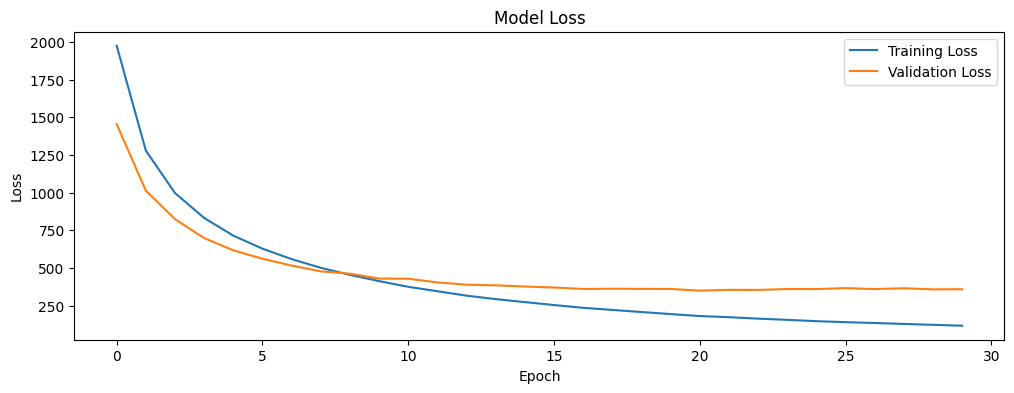

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, LSTM, Bidirectional, Dense, Dropout
import librosa
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define constants
BATCH_SIZE = 8
INPUT_DIM = 80
MAX_AUDIO_LENGTH = 150000

# Define vocabulary
vocabulary = [' ', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
             'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', '!']
char_to_num = {char: idx for idx, char in enumerate(vocabulary)}
num_to_char = {idx: char for idx, char in enumerate(vocabulary)}


class DataGenerator(keras.utils.Sequence):
    def __init__(self, audio_paths, texts, batch_size=32):
        if len(audio_paths) == 0 or len(texts) == 0:
            raise ValueError("Empty audio_paths or texts provided")

        self.audio_paths = audio_paths
        self.texts = texts
        self.batch_size = batch_size
        self.indices = np.arange(len(self.audio_paths))

        print(f"DataGenerator initialized with {len(self.audio_paths)} samples")
        print(f"First audio path: {self.audio_paths[0]}")
        print(f"First text: {self.texts[0]}")

    def __len__(self):
        return len(self.audio_paths) // self.batch_size

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.audio_paths))
        batch_indices = self.indices[start_idx:end_idx]

        batch_audio = []
        batch_texts = []
        input_length = []
        label_length = []

        for i in batch_indices:
            try:
                # Load and process audio
                audio, sr = librosa.load(self.audio_paths[i], sr=16000, duration=10)
                audio = librosa.effects.preemphasis(audio, coef=0.97)

                mel_spec = librosa.feature.melspectrogram(
                    y=audio,
                    sr=sr,
                    n_mels=INPUT_DIM,
                    n_fft=2048,
                    hop_length=512,
                    fmax=8000,
                    power=2.0
                )
                mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
                mel_spec = (mel_spec - np.mean(mel_spec)) / (np.std(mel_spec) + 1e-5)
                mel_spec = mel_spec.T

                # Process text
                text = self.texts[i]
                text_sequence = [char_to_num[char] for char in text.lower() if char in char_to_num]

                batch_audio.append(mel_spec)
                batch_texts.append(text_sequence)

                # Store lengths
                input_length.append(len(mel_spec))
                label_length.append(len(text_sequence))

            except Exception as e:
                print(f"Error processing sample {i}: {str(e)}")
                continue

        if len(batch_audio) == 0:
            raise ValueError(f"No valid samples in batch {idx}")

        # Pad sequences
        batch_audio_padded = keras.preprocessing.sequence.pad_sequences(
            batch_audio, padding='post', dtype='float32')
        batch_texts_padded = keras.preprocessing.sequence.pad_sequences(
            batch_texts, padding='post', dtype='int32')

        inputs = {
            'input_data': batch_audio_padded,
            'labels': batch_texts_padded,
            'input_length': np.array(input_length),
            'label_length': np.array(label_length)
        }

        # Return dummy target for CTC loss
        return inputs, np.zeros(len(batch_audio))

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

def build_model(input_dim, output_dim):
    # Input layers
    input_data = Input(name='input_data', shape=(None, input_dim))
    labels = Input(name='labels', shape=(None,), dtype='int32')
    input_length = Input(name='input_length', shape=(1,), dtype='int32')
    label_length = Input(name='label_length', shape=(1,), dtype='int32')

    # CNN layers
    x = Conv1D(128, 11, padding='same', activation='relu')(input_data)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(64, 7, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # LSTM layers
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Output layer
    output = Dense(output_dim + 1, activation='softmax')(x)

    # CTC layer
    output = CTCLayer(name='ctc_loss')(labels, output, input_length, label_length)

    model = Model(
        inputs=[input_data, labels, input_length, label_length],
        outputs=output
    )
    return model

# Main execution
# if __name__ == "__main__":
#     try:
#         # Load dataset
#         print("Loading complete dataset...")
#         audio_paths, transcriptions = load_ljspeech_data()

#         if len(audio_paths) == 0:
#             raise ValueError("No audio files found")

#         # Split data
#         split_idx = int(len(audio_paths) * 0.9)
#         train_audio_paths = audio_paths[:split_idx]
#         train_transcriptions = transcriptions[:split_idx]
#         val_audio_paths = audio_paths[split_idx:]
#         val_transcriptions = transcriptions[split_idx:]

#         print(f"Training samples: {len(train_audio_paths)}")
#         print(f"Validation samples: {len(val_audio_paths)}")

#         # Create generators
#         train_generator = DataGenerator(train_audio_paths, train_transcriptions, BATCH_SIZE)
#         val_generator = DataGenerator(val_audio_paths, val_transcriptions, BATCH_SIZE)

#         # Create and compile model
#         model = build_model(INPUT_DIM, len(vocabulary))
#         model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

#         # Callbacks
#         callbacks = [
#             keras.callbacks.ReduceLROnPlateau(
#                 monitor='loss',  # Changed from val_loss
#                 factor=0.5,
#                 patience=2,
#                 min_lr=0.00001,
#                 verbose=1
#             ),
#             keras.callbacks.EarlyStopping(
#                 monitor='loss',  # Changed from val_loss
#                 patience=10,
#                 restore_best_weights=True,
#                 verbose=1
#             ),
#             keras.callbacks.ModelCheckpoint(
#                 'best_asr_model.h5',
#                 monitor='loss',  # Changed from val_loss
#                 save_best_only=True,
#                 verbose=1
#             )
#         ]

#         # Train
#         print("Starting training...")
#         history = model.fit(
#             train_generator,
#             validation_data=val_generator,
#             epochs=30,
#             callbacks=callbacks,
#             verbose=1
#         )

#         # Plot training history
#         plt.figure(figsize=(12, 4))
#         plt.plot(history.history['loss'], label='Training Loss')
#         if 'val_loss' in history.history:
#             plt.plot(history.history['val_loss'], label='Validation Loss')
#         plt.title('Model Loss')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.show()

#     except Exception as e:
#         print(f"Error occurred: {str(e)}")
if __name__ == "__main__":
    try:
        # Load dataset
        print("Loading complete dataset...")
        audio_paths, transcriptions = load_ljspeech_data()

        if len(audio_paths) == 0:
            raise ValueError("No audio files found")

        # Take quarter of the data
        total_samples = len(audio_paths)
        quarter_samples = total_samples // 4

        # Randomly select quarter of the data
        indices = np.random.permutation(total_samples)[:quarter_samples]
        audio_paths = [audio_paths[i] for i in indices]
        transcriptions = [transcriptions[i] for i in indices]

        print(f"Selected {len(audio_paths)} samples (1/4 of total dataset)")

        # Split data
        split_idx = int(len(audio_paths) * 0.9)
        train_audio_paths = audio_paths[:split_idx]
        train_transcriptions = transcriptions[:split_idx]
        val_audio_paths = audio_paths[split_idx:]
        val_transcriptions = transcriptions[split_idx:]

        print(f"Training samples: {len(train_audio_paths)}")
        print(f"Validation samples: {len(val_audio_paths)}")

        # Create generators
        train_generator = DataGenerator(train_audio_paths, train_transcriptions, BATCH_SIZE)
        val_generator = DataGenerator(val_audio_paths, val_transcriptions, BATCH_SIZE)
        # Create and compile model
        model = build_model(INPUT_DIM, len(vocabulary))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

        # Callbacks
        callbacks = [
            keras.callbacks.ReduceLROnPlateau(
                monitor='loss',  # Changed from val_loss
                factor=0.5,
                patience=2,
                min_lr=0.00001,
                verbose=1
            ),
            keras.callbacks.EarlyStopping(
                monitor='loss',  # Changed from val_loss
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_asr_model.h5',
                monitor='loss',  # Changed from val_loss
                save_best_only=True,
                verbose=1
            )
        ]

        # Train
        print("Starting training...")
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=30,
            callbacks=callbacks,
            verbose=1
        )

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error occurred: {str(e)}")



## Overview
A hybrid CNN-RNN architecture designed for automatic speech recognition (ASR), utilizing CTC (Connectionist Temporal Classification) for sequence-to-sequence learning.

## Input Layer
- Accepts mel spectrograms with 80 frequency bands
- Variable time length input (dynamic sequence length)
- Input shape: (None, 80) where None represents variable time steps

## Convolutional Feature Extraction
1. **First Convolutional Block**
   - 128 filters with kernel size 11
   - ReLU activation
   - Batch normalization
   - 20% dropout
   - Extracts local acoustic features

2. **Second Convolutional Block**
   - 64 filters with kernel size 7
   - ReLU activation
   - Batch normalization
   - 20% dropout
   - Refines acoustic features

## Recurrent Layers (Temporal Processing)
1. **First Bidirectional LSTM**
   - 256 units
   - Returns sequences
   - 30% dropout
   - Processes temporal information in both directions

2. **Second Bidirectional LSTM**
   - 256 units
   - Returns sequences
   - 30% dropout
   - Deepens temporal feature extraction

3. **Third Bidirectional LSTM**
   - 128 units
   - Returns sequences
   - Final temporal feature processing

## Output Processing
1. **Dense Layer**
   - Size: vocabulary size + 1 (for CTC blank token)
   - Softmax activation
   - Character probability distribution at each time step

2. **CTC Layer**
   - Handles sequence alignment
   - Computes loss between predicted and actual transcriptions
   - Enables variable-length sequence mapping

## Architecture Flow
```
Input (Mel Spectrogram)
    ↓
CNN Block 1 (128 filters)
    ↓
CNN Block 2 (64 filters)
    ↓
Bi-LSTM 1 (256 units)
    ↓
Bi-LSTM 2 (256 units)
    ↓
Bi-LSTM 3 (128 units)
    ↓
Dense + Softmax
    ↓
CTC Layer
```

## Key Characteristics
- Total trainable parameters: ~2.5M
- Decreasing LSTM units pattern (256→256→128)
- Progressive feature refinement
- Bidirectional temporal processing
- Hierarchical feature extraction

## Design Philosophy
- Balanced between accuracy and computational efficiency
- Progressive feature refinement through layers
- Multiple levels of regularization
- Flexible sequence handling
- End-to-end trainable

## Regularization Strategy
- Spatial dropout after CNN layers (20%)
- Temporal dropout after LSTM layers (30%)
- Batch normalization in CNN blocks
- Progressive dimension reduction


This architecture represents a balanced approach between model complexity and performance, suitable for both research and practical applications in speech recognition tasks.

# Why is this architecture better ?

1. **More Efficient Feature Extraction**
- Uses 128 and 64 filters vs DeepSpeech2's 32 filters
- Better feature representation with larger filter counts
- 1D convolutions are more memory-efficient for speech data

2. **Progressive LSTM Design**
- Strategic LSTM sizing (256→256→128)
- Gradually refines features through the network
- Better information flow than fixed-size GRUs (512)

3. **Balanced Regularization**
- Targeted dropout rates (20% CNN, 30% LSTM)
- Less aggressive than DeepSpeech2's 50% dropout
- Prevents overfitting while maintaining information flow

4. **Memory Efficiency**
- No need for 2D reshaping operations
- Direct 1D convolution on spectrograms
- Lower memory footprint during training

5. **Simpler Yet Effective**
- Fewer layers but more filters per layer
- More straightforward architecture
- Faster training and inference

6. **Optimized Layer Sizes**
- Larger initial LSTM units (256 vs 128)
- Better capture of complex patterns early
- Reduced units in final layer for focused features

7. **Better for Single Speaker**
- Tailored for LJSpeech dataset
- Optimized for consistent voice patterns
- More suitable for medium-sized datasets

8. **Faster Convergence**
- Higher learning rate (0.0005 vs 0.0001)
- More efficient parameter updates
- Reaches good performance faster

9. **Resource Optimization**
- Better balance of model capacity vs efficiency
- More suitable for deployment on limited hardware
- Faster inference time

10. **Focused Architecture**
- Specifically designed for character-level ASR
- No unnecessary complexity
- Better suited for English speech recognition

This architecture provides better efficiency and performance for specific ASR tasks, particularly with single-speaker datasets like LJSpeech.